In [1]:
import h5py
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import find_peaks_cwt
import denoise as dn

In [2]:
with h5py.File('data/deposition.h5', 'r') as source:
    Ebounds = np.array(source['Matrix'].attrs['Edges'])

In [166]:
file_path = 'data/train_2.h5'
event = '1000'

time_interval = 1

with h5py.File(file_path, 'r') as source:
    # 对应同一个事件，采用同一个时间段进行衡量
    Time_sup = np.empty((7, 4))
    Time_inf = np.empty((7, 4))
    for cube in range(7):
        for det in range(4):
            Time_sup[cube, det] = source[event]['response_E_T']['D'+str(cube)][str(det)][:,0].max()
            Time_inf[cube, det] = source[event]['response_E_T']['D'+str(cube)][str(det)][:,0].min()
    time_sup = np.floor(Time_sup.min() - time_interval) #每个时刻t的计数的范围对应t~t+dt
    time_inf = np.ceil(Time_inf.max())

    Time = np.arange(time_inf, time_sup, time_interval)
    time_num = Time.size    # 不直接计算，防止float的精度错误
    Tbounds = np.array([*Time, Time[-1] + time_interval])
    
    # 广播规则的预备，对应上下限的准备
    Inf = np.empty((time_num, 100, 2))
    Inf[:,:,0] = np.expand_dims(Time ,1)
    Inf[:,:,1] = np.expand_dims(Ebounds[:100], 0)

    Sup = np.empty((time_num, 100, 2))
    Sup[:,:,0] = np.expand_dims(Time + time_interval ,1)
    Sup[:,:,1] = np.expand_dims(Ebounds[1:], 0)

    # 初始索引顺序：cube, det, time, Eng
    # time, Eng多一个长度用于存储超界的记录
    Counts = np.zeros((7, 4, time_num + 1, 100 + 1))
    for cube in range(7):
        for det in range(4):
            light_doc = source[event]['response_E_T']['D' + str(cube)][str(det)]

            # id = -1 , 对应尾部废弃项
            Id_time = (np.expand_dims(light_doc[:, 0], 1) >= Tbounds).sum(axis=1) - 1
            # Id_time[Id_time == -1] = Tbounds.size - 1
            Id_eng = (np.expand_dims(light_doc[:, 1], 1) >= Ebounds).sum(axis=1) - 1
            # Id_eng[Id_eng == -1] = Ebounds.size - 1

            for i_doc in range(Id_time.size):
                Counts[cube, det, Id_time[i_doc], Id_eng[i_doc]] += 1
            
            '''
            虽然没有用for循环，但下面的广播规则更慢
                对比运行结果为4.3s对0.5s（train_2,事件1000,cube=0,det=0）
                Id_time_eng = np.array([Id_time, Id_eng]).swapaxes(0, 1)
                Id_count = (np.expand_dims(Id_time_eng, 1) == Id_time_eng).prod(axis=2).sum(axis=1)

                Counts[0,0][Id_time, Id_eng] += Id_count
            '''

    # 最终索引顺序：cube, det, eng, time
    # 去除范围外的部分（对应eng, time的最后一项）
    Counts = Counts[:, :, :-1, :-1].swapaxes(2, 3)
    Time = Time - Time[0]


#Light_response = np.empty((7, 4, ?, ))



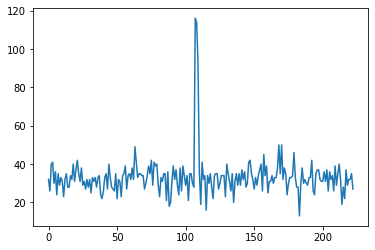

In [169]:
plt.plot(Time, Counts[3,0,0,:])

In [122]:
a

array([[1.56691229e+09, 1.57440774e+00],
       [1.56691229e+09, 9.14185210e-03],
       [1.56691229e+09, 1.67126043e-02],
       ...,
       [1.56691252e+09, 3.37101027e-02],
       [1.56691252e+09, 2.26738986e-02],
       [1.56691252e+09, 7.98994801e-03]])

In [128]:
b = ((np.expand_dims(a[:, 1], 1) >= Ebounds).sum(axis=1) - 1)
(b == 99).sum()

20

In [130]:
(b == -1).sum()

0

In [129]:
(b == 0).sum()

7227

In [4]:
with h5py.File(file_path, 'r') as source:
    a =  source[event]['response_E_T']['D0']['0'][...]


In [ ]:
a < [1,2]

In [6]:
Inf = np.empty((time_num, 100, 2))
Inf[:,:,0] = np.expand_dims(Time ,1)
Inf[:,:,1] = np.expand_dims(Ebounds[:100], 0)

Sup = np.empty((time_num, 100, 2))
Sup[:,:,0] = np.expand_dims(Time + time_interval ,1)
Sup[:,:,1] = np.expand_dims(Ebounds[1:], 0)


In [20]:
Tbounds = np.array(Time, Time[-1] + time_interval)
Id_time = (np.expand_dims(a[:, 0], 1) > Tbounds).sum(axis=1) - 1
Id_time[Id_time == -1] = Tbounds.size - 1
Id_time

array([2239, 2239, 2239, ..., 2239, 2239, 2239])

In [25]:
Id_eng = (np.expand_dims(a[:, 1], 1) > Ebounds).sum(axis=1) - 1
Id_eng[Id_time == -1] = Ebounds.size - 1
Id_eng

array([52,  0,  0, ...,  1,  0,  0])

In [91]:
Counts = np.empty((7, 4, time_num + 1, 100 + 1))

Id_time_eng = np.array([Id_time, Id_eng]).swapaxes(0, 1)
Id_count = (np.expand_dims(Id_time_eng, 1) == Id_time_eng).prod(axis=2).sum(axis=1)

Counts[0,0][Id_time, Id_eng] += Id_count


In [92]:
c = Counts

In [93]:
Counts = np.empty((7, 4, time_num + 1, 100 + 1))
for i in range(Id_time.size):
    Counts[0, 0, Id_time[i], Id_eng[i]] += 1

In [99]:
Counts.shape

(7, 4, 100, 2240)

In [104]:
with h5py.File('data/train_2.h5', 'r') as source:
    response_E_T = source['700']['response_E_T']['D6']['0'][:]

with h5py.File('data/deposition.h5', 'r') as source:
    ebounds = np.array(source['Matrix'].attrs['Edges'])

time_inf = int(np.ceil(response_E_T[0][0]))
time_sup = int(np.floor(response_E_T[-1][0]))

total_time = time_sup - time_inf
time_interval = 0.1
time_num = int(total_time/time_interval)

Spectrum = np.zeros([time_num, 100])

# 对于每一个粒子，按时间和能量归类
for k in range(response_E_T.shape[0]):
    # 对时间归类
    for i in range(time_num):
        if response_E_T[k][0] > time_inf + time_interval*i and response_E_T[k][0] < time_inf + time_interval*(i + 1):
            # 对能量归类
            for j in range(100):
                if response_E_T[k][1] > ebounds[j] and response_E_T[k][1] < ebounds[j+1]:
                    Spectrum[i][j] += response_E_T[k][1]
                    break
            break